In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, GRU, LSTM, Bidirectional, SpatialDropout1D, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

def remove_english_stopwords(text):
   stop_words = set(stopwords.words('english'))
   word_tokens = word_tokenize(text)
   filtered_text = [word for word in word_tokens if not word in stop_words]
   return ' '.join(filtered_text)

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def preprocess(text):
    text = remove_nonaplhanumeric(text) 
    text = remove_unnecessary_char(text) 
    text = remove_english_stopwords(text) 
    return text

In [4]:
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv',index_col='id')
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_data['comment_text'] = train_data['comment_text'].apply(preprocess)
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation Why edits made username Hardcore M...,0,0,0,0,0,0
000103f0d9cfb60f,D aww He matches background colour I seemingly...,0,0,0,0,0,0
000113f07ec002fd,Hey man I really trying edit war It guy consta...,0,0,0,0,0,0
0001b41b1c6bb37e,More I make real suggestions improvement I won...,0,0,0,0,0,0
0001d958c54c6e35,You sir hero Any chance remember page,0,0,0,0,0,0


In [6]:
train_data['comment_length'] = train_data['comment_text'].apply(lambda row: len(row))
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0000997932d777bf,Explanation Why edits made username Hardcore M...,0,0,0,0,0,0,188
000103f0d9cfb60f,D aww He matches background colour I seemingly...,0,0,0,0,0,0,90
000113f07ec002fd,Hey man I really trying edit war It guy consta...,0,0,0,0,0,0,149
0001b41b1c6bb37e,More I make real suggestions improvement I won...,0,0,0,0,0,0,398
0001d958c54c6e35,You sir hero Any chance remember page,0,0,0,0,0,0,37


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

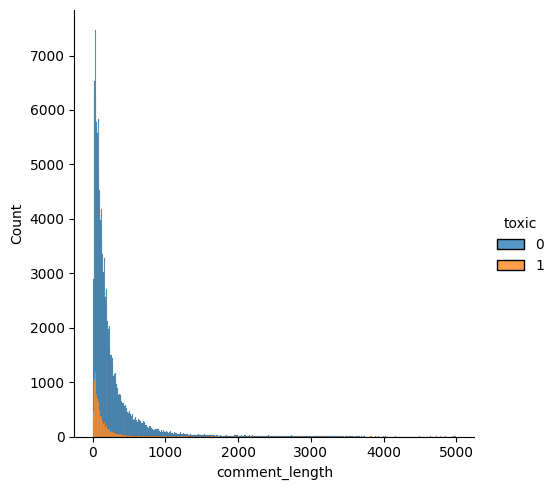

In [7]:
import seaborn as sns
sns.displot(
    data=train_data, 
    x="comment_length", 
    hue='toxic',
    multiple="stack",
)

In [8]:
toxic_data = train_data[train_data['toxic'] == 1]
toxic_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
0005c987bdfc9d4b,Hey talk What exclusive group WP TALIBANS good...,1,0,0,0,0,0,208
0007e25b2121310b,Bye Don look come think comming back Tosser,1,0,0,0,0,0,43
001810bf8c45bf5f,You gay antisemmitian Archangel WHite Tiger Me...,1,0,1,0,1,1,425
00190820581d90ce,FUCK YOUR FILTHY MOTHER IN THE ASS DRY,1,0,1,0,1,0,38


In [9]:
print(
    'max', toxic_data['comment_length'].max(),
    'min', toxic_data['comment_length'].min(),
    'mean', toxic_data['comment_length'].mean(),
    'median', toxic_data['comment_length'].median(),
    '75%', toxic_data['comment_length'].quantile(0.75),
)

max 5000 min 4 mean 209.4926114816268 median 84.0 75% 181.0


In [10]:
max_comment_len = 300

In [11]:
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv',index_col='id')
test_data.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
test_labels_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv',index_col='id')
test_labels_data.head()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [13]:
test_data = test_data.join(test_labels_data)
test_data = test_data[test_data['toxic'] != -1]
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [14]:
num_words = 10000
encoder = TextVectorization(max_tokens=num_words)
encoder.adapt(train_data['comment_text'].values)

from tensorflow.keras.layers import BatchNormalization

model_gru = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
        input_length=max_comment_len,
    ),
    SpatialDropout1D(0.5),
    Bidirectional(GRU(20, return_sequences=True)),
    BatchNormalization(),
    Bidirectional(GRU(20)),
    Dense(6, activation='sigmoid'),
])


In [15]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [16]:
model_gru_save_path = '/kaggle/working/toxic_model_gru'
checkpoint_callback_gru = ModelCheckpoint(
    model_gru_save_path, 
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_format='tf',
)

In [17]:
!rm -r /kaggle/working/toxic_model_gru

rm: cannot remove '/kaggle/working/toxic_model_gru': No such file or directory


In [18]:
x_train1 = train_data['comment_text'].values
y_train1 = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [19]:
from sklearn.model_selection import train_test_split 
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,train_size=0.8,shuffle=True,random_state=42)

In [20]:
x_train[:2]

array(['Grandma Terri Should Burn Trash Grandma Terri trash I hate Grandma Terri F K HELL 71 74 76 40',
       '9 May 2009 UTC It would easiest admit member involved Portuguese Lodge would requirement acknowledge whether previous account Carlos Botelho good record I would remove sockpuppet template irrelevant WP COI permits people edit articles MSJapan means careful ensuring references back edits NPOV upheld 20 29'],
      dtype=object)

In [21]:
y_train[:2]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [22]:
history_gru = model_gru.fit(
    x_train, 
    y_train, 
    epochs=5, # 15
    batch_size=512,
    validation_data=(x_val,y_val),
    callbacks=[checkpoint_callback_gru],
)

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.8035 - auc: 0.8823
Epoch 1: val_accuracy improved from -inf to 0.66354, saving model to /kaggle/working/toxic_model_gru
250/250 [==============================] - 162s 567ms/step - loss: 0.1320 - accuracy: 0.8035 - auc: 0.8823 - val_loss: 0.0834 - val_accuracy: 0.6635 - val_auc: 0.9800
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9940 - auc: 0.9808
Epoch 2: val_accuracy improved from 0.66354 to 0.99411, saving model to /kaggle/working/toxic_model_gru
250/250 [==============================] - 117s 470ms/step - loss: 0.0528 - accuracy: 0.9940 - auc: 0.9808 - val_loss: 0.0535 - val_accuracy: 0.9941 - val_auc: 0.9833
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9940 - auc: 0.9843
Epoch 3: val_accuracy did not improve from 0.99411
250/250 [==============================] - 81s 323ms/step - loss: 0.0467 - accuracy

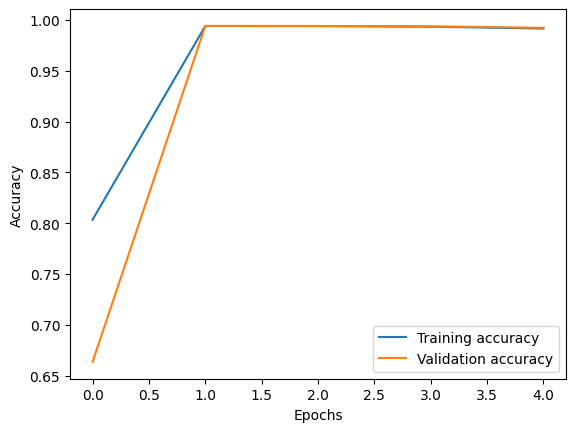

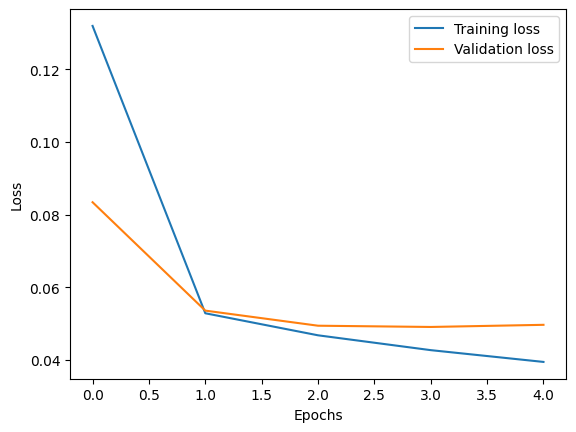

In [23]:
plt.plot(history_gru.history['accuracy'], 
         label='Training accuracy')
plt.plot(history_gru.history['val_accuracy'], 
         label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history_gru.history['loss'], 
         label='Training loss')
plt.plot(history_gru.history['val_loss'], 
         label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
x_test = test_data['comment_text'].values
y_test = test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [25]:
model_gru.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 56s 28ms/step - loss: 0.1146 - accuracy: 0.9960 - auc: 0.9616


[0.11464431136846542, 0.9960142374038696, 0.9615722894668579]

In [26]:
saved_model = load_model(model_gru_save_path)

In [27]:
test_data[test_data['toxic']==1][:5]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...,1,0,1,0,1,1
0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0
001d739c97bc2ae4,How dare you vandalize that page about the HMS...,1,0,0,0,0,0
001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur...",1,0,1,0,1,0


In [28]:
test_data[test_data['toxic']==1][:5]['comment_text'].values

array(['== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.',
       'DJ Robinson is gay as hell! he sucks his dick so much!!!!!',
       ':Fuck off, you anti-semitic cunt.  |',
       "How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",
       '::No, he is an arrogant, self serving, immature idiot. Get it right.'],
      dtype=object)

In [29]:
test_labels = saved_model.predict(test_data[test_data['toxic']==1][:5]['comment_text'].values)
for labels in test_labels:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 5s 5s/step
[0.33, 0.01, 0.06, 0.01, 0.09, 0.02]
[0.98, 0.21, 0.89, 0.05, 0.77, 0.2]
[0.99, 0.47, 0.95, 0.11, 0.91, 0.27]
[0.66, 0.01, 0.11, 0.01, 0.18, 0.03]
[0.96, 0.1, 0.76, 0.02, 0.68, 0.11]


In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts_val = saved_model.predict(x_val, verbose=1)

for threshold in thresholds:
  y_pred_val = (predicts_val > threshold)
  clr = classification_report(y_val, y_pred_val)
  accuracy = accuracy_score(y_val, y_pred_val)
  f1 = f1_score(y_val, y_pred_val, average='weighted')
  precision = precision_score(y_val, y_pred_val, average='weighted')
  recall = recall_score(y_val, y_pred_val, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n\nAccuracy: {accuracy}\n")

998/998 [==============================] - 17s 17ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.43      0.95      0.59      3056
           1       0.23      0.88      0.36       321
           2       0.52      0.95      0.67      1715
           3       0.05      0.20      0.08        74
           4       0.42      0.95      0.58      1614
           5       0.13      0.62      0.22       294

   micro avg       0.40      0.92      0.55      7074
   macro avg       0.30      0.76      0.42      7074
weighted avg       0.42      0.92      0.58      7074
 samples avg       0.06      0.09      0.07      7074

F1 Score: 0.5768267067473748
Precision: 0.4233234915297701
Recall: 0.9225332202431439

Accuracy: 0.8000939996866677

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.56      0.91      0.69      3056
           1       0.32      0.78      0.45       321
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      3056
           1       0.45      0.48      0.46       321
           2       0.76      0.84      0.80      1715
           3       0.33      0.01      0.03        74
           4       0.65      0.80      0.72      1614
           5       0.22      0.01      0.03       294

   micro avg       0.70      0.77      0.73      7074
   macro avg       0.52      0.50      0.47      7074
weighted avg       0.68      0.77      0.71      7074
 samples avg       0.07      0.07      0.07      7074

F1 Score: 0.7140992542811323
Precision: 0.6758099823725429
Recall: 0.7719819055696918

Accuracy: 0.9044649851167162

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      3056
           1       0.51      0.28      0.36       321
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.89      0.70      0.79      3056
           1       0.75      0.05      0.09       321
           2       0.89      0.68      0.77      1715
           3       0.00      0.00      0.00        74
           4       0.76      0.57      0.65      1614
           5       0.00      0.00      0.00       294

   micro avg       0.86      0.60      0.71      7074
   macro avg       0.55      0.33      0.38      7074
weighted avg       0.81      0.60      0.68      7074
 samples avg       0.06      0.05      0.06      7074

F1 Score: 0.6781958376885269
Precision: 0.806328192338564
Recall: 0.6005089058524173

Accuracy: 0.9194736017546609

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      3056
           1       0.00      0.00      0.00       321
  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts = saved_model.predict(x_test, verbose=1)

for threshold in thresholds:
  y_pred = (predicts > threshold)
  f1 = f1_score(y_test, y_pred, average='weighted')
  accuracy = accuracy_score(y_test, y_pred)
  clr = classification_report(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n\nAccuracy: {accuracy}\n")

2000/2000 [==============================] - 52s 26ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.14      0.99      0.25      6090
           1       0.11      0.89      0.19       367
           2       0.19      0.96      0.32      3691
           3       0.07      0.23      0.11       211
           4       0.15      0.98      0.26      3427
           5       0.13      0.70      0.21       712

   micro avg       0.15      0.95      0.26     14498
   macro avg       0.13      0.79      0.22     14498
weighted avg       0.15      0.95      0.26     14498
 samples avg       0.06      0.09      0.07     14498

F1 Score: 0.26474975001415885
Precision: 0.15431971451905235
Recall: 0.9502690026210512

Accuracy: 0.34993278939635497

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.19      0.98      0.31      6090
           1       0.17      0.77      0.28       36

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.3
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.24      0.96      0.38      6090
           1       0.25      0.68      0.36       367
           2       0.40      0.89      0.56      3691
           3       0.06      0.01      0.02       211
           4       0.32      0.89      0.47      3427
           5       0.32      0.15      0.20       712

   micro avg       0.29      0.87      0.43     14498
   macro avg       0.26      0.60      0.33     14498
weighted avg       0.30      0.87      0.43     14498
 samples avg       0.07      0.09      0.07     14498

F1 Score: 0.4309090034048315
Precision: 0.29991769653226613
Recall: 0.8668092150641468

Accuracy: 0.6396261214792585

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.29      0.94      0.44      6090
           1       0.31      0.54      0.39       367


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.35      0.92      0.51      6090
           1       0.37      0.39      0.38       367
           2       0.59      0.78      0.67      3691
           3       0.00      0.00      0.00       211
           4       0.50      0.75      0.60      3427
           5       0.56      0.01      0.01       712

   micro avg       0.42      0.77      0.55     14498
   macro avg       0.39      0.47      0.36     14498
weighted avg       0.45      0.77      0.53     14498
 samples avg       0.08      0.08      0.07     14498

F1 Score: 0.5349240653931046
Precision: 0.45096964549189705
Recall: 0.771485722168575

Accuracy: 0.7792678733314576

Threshold: 0.6
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.42      0.88      0.57      6090
           1       0.41      0.20      0.27       367
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.50      0.83      0.62      6090
           1       0.49      0.07      0.12       367
           2       0.75      0.61      0.67      3691
           3       0.00      0.00      0.00       211
           4       0.67      0.52      0.59      3427
           5       0.00      0.00      0.00       712

   micro avg       0.58      0.63      0.60     14498
   macro avg       0.40      0.34      0.33     14498
weighted avg       0.57      0.63      0.58     14498
 samples avg       0.07      0.06      0.06     14498

F1 Score: 0.5761792528177374
Precision: 0.5743465884927283
Recall: 0.6278797075458684

Accuracy: 0.8586076463784426

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.62      0.74      0.67      6090
           1       0.17      0.00      0.01       367
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

In [32]:
!zip -r /kaggle/working/toxic_model_bidir_gru.zip /kaggle/working/toxic_model_bidir_gru

  adding: kaggle/working/toxic_model_gru/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/saved_model.pb (deflated 89%)
  adding: kaggle/working/toxic_model_gru/keras_metadata.pb (deflated 91%)
  adding: kaggle/working/toxic_model_gru/assets/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/variables/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/toxic_model_gru/variables/variables.index (deflated 66%)
  adding: kaggle/working/toxic_model_gru/fingerprint.pb (stored 0%)
